In [5]:
import numpy as np
import optuna
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv("../data/processed/train.csv")
test = pd.read_csv("../data/processed/test.csv")

In [10]:
target = "NObeyesdad"
random_state = 0

In [3]:
X = train.drop([target], axis=1)
y = train[target]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=random_state
)

In [12]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18276, 23)
X_test shape: (4569, 23)
y_train shape: (18276,)
y_test shape: (4569,)


In [13]:
# Define the objective function for Optuna optimization
def objective(trial, X_train, y_train, X_test, y_test):
    # Define parameters to be optimized for the LGBMClassifier
    param = {
        "objective": "multiclass",
        "metric": "multi_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": random_state,
        "num_class": 7,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
        "n_estimators": trial.suggest_int("n_estimators", 400, 600),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
        "max_depth": trial.suggest_int("max_depth", 6, 14),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
    }

    # Create an instance of LGBMClassifier with the suggested parameters
    lgbm_classifier = LGBMClassifier(**param)

    # Fit the classifier on the training data
    lgbm_classifier.fit(X_train, y_train)

    # Evaluate the classifier on the test data
    score = lgbm_classifier.score(X_test, y_test)

    return score

In [14]:
# Set up the sampler for Optuna optimization
# Using Tree-structured Parzen Estimator sampler for optimization
sampler = optuna.samplers.TPESampler(seed=random_state)  

In [15]:
# Create a study object for Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)

[I 2024-02-25 15:32:27,050] A new study created in memory with name: no-name-aef9a1aa-8f4c-426c-b336-02fc31367f9d


In [16]:
# Run the optimization process
study.optimize(lambda trial: objective(trial, X_train, y_train, X_test, y_test), n_trials=100)

[I 2024-02-25 15:33:18,032] Trial 0 finished with value: 0.915517618734953 and parameters: {'learning_rate': 0.03195254015709299, 'n_estimators': 543, 'lambda_l1': 0.011027633760716438, 'lambda_l2': 0.04179532731987587, 'max_depth': 9, 'colsample_bytree': 0.6875364678399938, 'subsample': 0.8875174422525385, 'min_child_samples': 46}. Best is trial 0 with value: 0.915517618734953.
[I 2024-02-25 15:33:41,227] Trial 1 finished with value: 0.9128912234624644 and parameters: {'learning_rate': 0.048546510420041177, 'n_estimators': 477, 'lambda_l1': 0.012917250380826646, 'lambda_l2': 0.041155796790116175, 'max_depth': 11, 'colsample_bytree': 0.8553579829755966, 'subsample': 0.8142072116395774, 'min_child_samples': 13}. Best is trial 0 with value: 0.915517618734953.
[I 2024-02-25 15:34:08,070] Trial 2 finished with value: 0.9183628802801488 and parameters: {'learning_rate': 0.010808735897613029, 'n_estimators': 567, 'lambda_l1': 0.012781567509498503, 'lambda_l2': 0.05480048592987276, 'max_depth

In [17]:
# Get the best parameters after optimization
best_params = study.best_params

In [19]:
print(best_params)

{'learning_rate': 0.012895148872894106, 'n_estimators': 457, 'lambda_l1': 0.008179204992451842, 'lambda_l2': 0.022669285325135756, 'max_depth': 12, 'colsample_bytree': 0.4240998469631964, 'subsample': 0.9658150639983177, 'min_child_samples': 46}


In [20]:
best_params

{'learning_rate': 0.012895148872894106,
 'n_estimators': 457,
 'lambda_l1': 0.008179204992451842,
 'lambda_l2': 0.022669285325135756,
 'max_depth': 12,
 'colsample_bytree': 0.4240998469631964,
 'subsample': 0.9658150639983177,
 'min_child_samples': 46}

In [21]:
lgbm_params = {
    "objective": "multiclass",  # Objective function for the model
    "metric": "multi_logloss",  # Evaluation metric
    "verbosity": -1,  # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",  # Gradient boosting type
    "random_state": 0,  # Random state for reproducibility
    "num_class": 7,  # Number of classes in the dataset
    "learning_rate": 0.012895148872894106,  # Learning rate for gradient boosting
    "n_estimators": 457,  # Number of boosting iterations
    "lambda_l1": 0.008179204992451842,  # L1 regularization term
    "lambda_l2": 0.022669285325135756,  # L2 regularization term
    "max_depth": 12,  # Maximum depth of the trees
    "colsample_bytree": 0.4240998469631964,  # Fraction of features to consider for each tree
    "subsample": 0.9658150639983177,  # Fraction of samples to consider for each boosting iteration
    "min_child_samples": 46,  # Minimum number of data needed in a leaf
}

### LightGBM classifier with best parameters

In [22]:
lgbm_classifier = LGBMClassifier(**lgbm_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)

## Evaluation

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [31]:
accuracy_score(y_test, y_pred)

0.9218647406434668

In [24]:
print(classification_report(y_test, y_pred))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.96      0.95       544
      Normal_Weight       0.88      0.91      0.89       680
     Obesity_Type_I       0.91      0.92      0.92       636
    Obesity_Type_II       0.97      0.98      0.98       727
   Obesity_Type_III       0.99      1.00      1.00       901
 Overweight_Level_I       0.82      0.78      0.80       493
Overweight_Level_II       0.86      0.83      0.85       588

           accuracy                           0.92      4569
          macro avg       0.91      0.91      0.91      4569
       weighted avg       0.92      0.92      0.92      4569



#### Confusion matrix

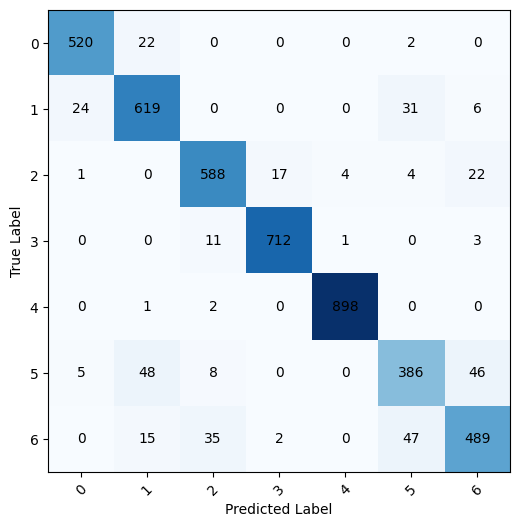

In [27]:
# Confusion matrix
plt.figure(figsize=(15, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
conf_labels = [f"{i}" for i in range(conf_matrix.shape[0])]
conf_matrix_df = pd.DataFrame(conf_matrix, columns=conf_labels, index=conf_labels)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.xticks(np.arange(conf_matrix.shape[0]), conf_labels, rotation=45)
plt.yticks(np.arange(conf_matrix.shape[0]), conf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")
plt.grid(False)
plt.show()

#### Feature importance

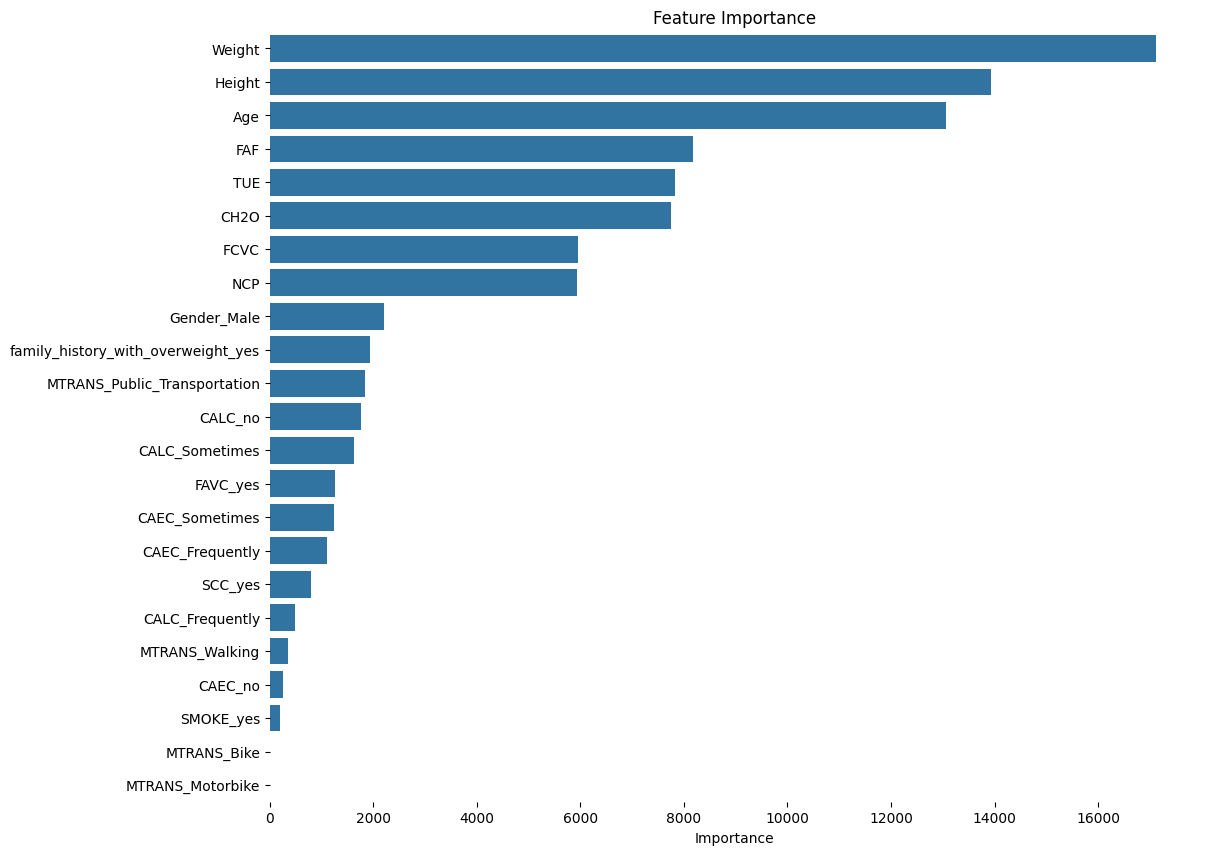

In [32]:
from lightgbm import LGBMClassifier, plot_importance

feature_importance = lgbm_classifier.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importance}
)
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)
plt.figure(figsize=(12, 10))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("")
sns.despine(left=True, bottom=True)
plt.show()

## Prediction on test data

In [33]:
predictions = lgbm_classifier.predict(test)

In [34]:
predictions

array(['Obesity_Type_II', 'Overweight_Level_I', 'Obesity_Type_III', ...,
       'Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_II'],
      dtype=object)

## Submission

In [39]:
submission = pd.read_csv("../data/raw/sample_submission.csv")
submission["NObeyesdad"] = predictions
submission.to_csv("../data/submissions/submission1_lightgbm_no_feature_eng.csv", index=False)

In [38]:
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
